# Imports & Setup

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.gridspec as gridspec

from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
from tabulate import tabulate
from tsfeatures import tsfeatures
from scipy.spatial.distance import cdist

In [46]:
# Configure seaborn plot style: set background color and use dark grid
sns.set(rc={'axes.facecolor':'#E6E6E6'}, style='darkgrid')

In [47]:
df_train = pd.read_csv("data/train.csv", index_col=0)

In [48]:
df_test = pd.read_csv("data/test.csv", index_col=0)

In [49]:
df_train.ds = pd.to_datetime(df_train.ds, format="%Y-%m-%d")

In [50]:
df_train.head()

,unique_id,ds,y
0,F00001015_CLR000021,2022-03-13,0.0
1,F00001015_CLR000023,2022-03-13,0.0
2,F00001111_151304TCX,2022-03-13,0.0
3,F00001111_193924TPX,2022-03-13,0.0
4,F00001111_CLR000021,2022-03-13,0.0


In [51]:
df_train["unique_id"].nunique()

700

# III. Feature-based clustering

## 1. Feature extraction

In [52]:
ts = df_train[df_train['y']!=0]

In [53]:
empty = [i for i in df_train["unique_id"].unique() if i not in ts["unique_id"].unique()]
empty

['F10000047_CLR000021',
 'F24100106_CLR001486',
 'F24200090_CLR000021',
 'F24400186_CLR000021',
 'F24400186_CLR000337',
 'F24400186_CLR001108',
 'F24400186_CLR998689',
 'M10000059_CLR000021',
 'M24300005_CLR001978',
 'M24300006_CLR000589',
 'M24400088_190414TCX',
 'M24400088_CLR000021']

In [54]:
# remove empty timeseries
df_train = df_train[~df_train["unique_id"].isin(empty)]

In [55]:
df_train.unique_id.nunique()

688

In [56]:
extracted_tsfeatures = ts.groupby("unique_id").count().reset_index()

In [57]:
extracted_features = tsfeatures(df_train, freq=7)

In [58]:
featurests = extracted_tsfeatures[["unique_id", "y"]]

In [59]:
featurests.columns = ["unique_id", "series_length"]
features = extracted_features[["unique_id", "trend", "seasonal_strength", "x_acf1"]]

In [60]:
features = featurests.set_index("unique_id").join(features.set_index("unique_id"), on="unique_id")

In [61]:
median_df = ts.groupby('unique_id')['y'].median()

In [62]:
features = features.join(median_df, on="unique_id")

In [63]:
features.columns = ['series_length', 'trend', 'seasonal_strength', 'x_acf1', 'median']

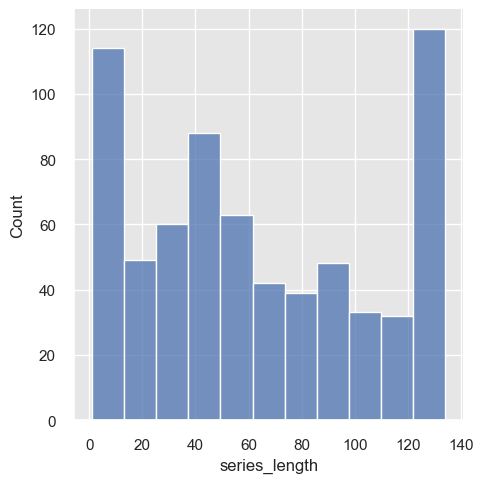

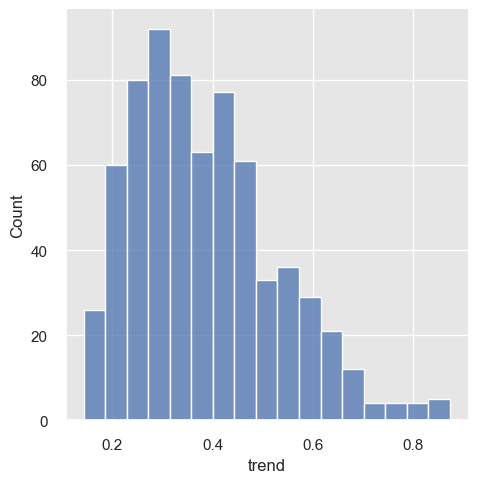

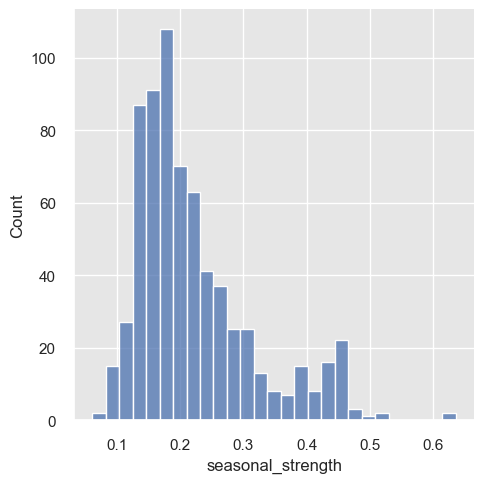

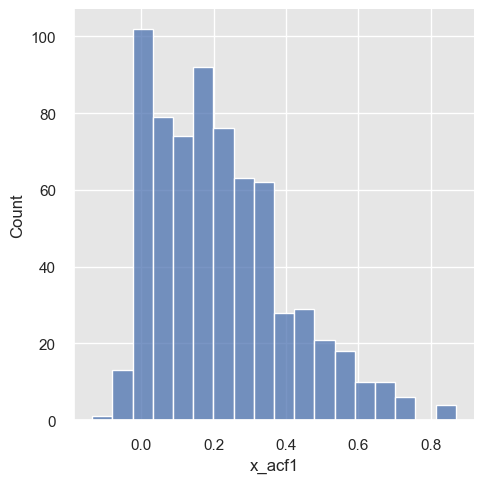

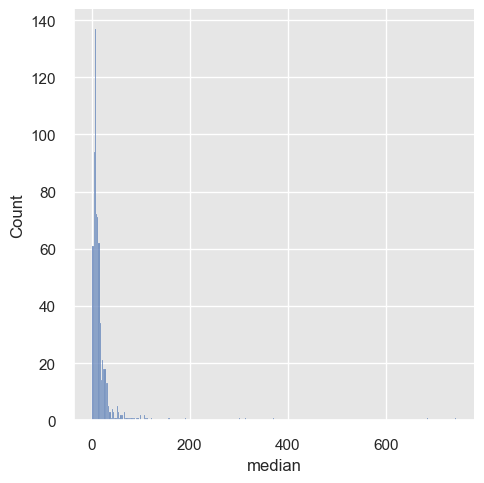

In [64]:
for i in features.columns:
    sns.displot(features[i])
    plt.show()

In [65]:
# Display the first few rows of the scaled data
features.shape

(688, 5)

In [66]:
features.fillna(0, inplace=True)

## 2. Feature scaling

In [67]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns not to be scaled
columns_to_exclude = ['unique_id']

# List of columns to be scaled
columns_to_scale = features.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
features_scaled = features.copy()

# Applying the scaler to the necessary columns in the dataset
features_scaled[columns_to_scale] = scaler.fit_transform(features_scaled[columns_to_scale])

## 3. Dimension reduction with PCA

In [68]:
# Apply PCA
pca = PCA().fit(features_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

According to the KneeLocator, the value of k is 2


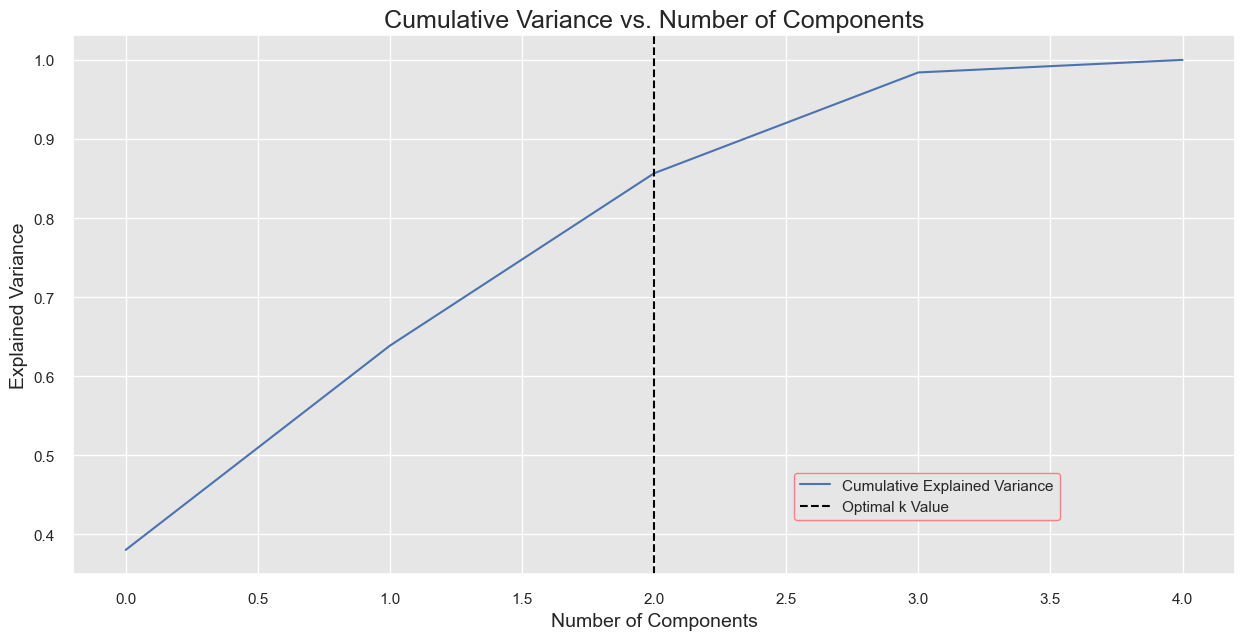

In [69]:
plt.figure(figsize=(15,7))

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance)

# Plot optimal k value line
kn = KneeLocator(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, curve='concave',direction='increasing')
optimal_k = kn.knee
optimal_k_line = plt.axvline(optimal_k, color='#000000', linestyle='--')
print(f"According to the KneeLocator, the value of k is {optimal_k}")

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

plt.legend(handles=[lineplot, optimal_k_line],
            labels=['Cumulative Explained Variance', 'Optimal k Value'],
            loc=(0.62, 0.1),
            frameon=True,
            framealpha=1.0,
            edgecolor='#ff8080')

In [70]:
# Creating a PCA object with optimal_k components
pca = PCA(n_components=optimal_k)

# Fitting and transforming the original data to the new PCA dataframe
features_pca = pca.fit_transform(features_scaled)

# Creating a new dataframce from the PCA dataframe, with columns labelec PC1, PC2, etc
features_pca = pd.DataFrame(features_pca, columns=['PC'+str(i+1) for i in range(0, pca.n_components_)])

# Adding the CustomerNumber index back to the new PCA dataframe
features_pca.index = features_scaled.index

In [71]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color: #ff8080' if i in top3 else '' for i in column.index]

# Create the PCA components DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)], index=features_scaled.columns)
pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2
series_length,-0.151874,-0.601685
trend,0.705157,-0.014540
seasonal_strength,0.105995,0.739007
x_acf1,0.684432,-0.232280
median,-0.002465,0.194109


## 4. KMeans clustering

In [72]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []
    
    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        sil_score = round(silhouette_score(df, labels),3)
        silhouette_scores.append(sil_score)
        
    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
                

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the score text to the plot
        score = silhouette_score(df, km.labels_)
        calinski_score = round(calinski_harabasz_score(df, km.labels_),3)
        davies_score = round(davies_bouldin_score(df, km.labels_),3)
        ax.text(0.97, 0.22, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')
        ax.text(0.97, 0.12, f'Calinski Score: {calinski_score:.2f}',fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')
        ax.text(0.97, 0.02, f'Davies Bouldin Score: {davies_score:.2f}',fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')      

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

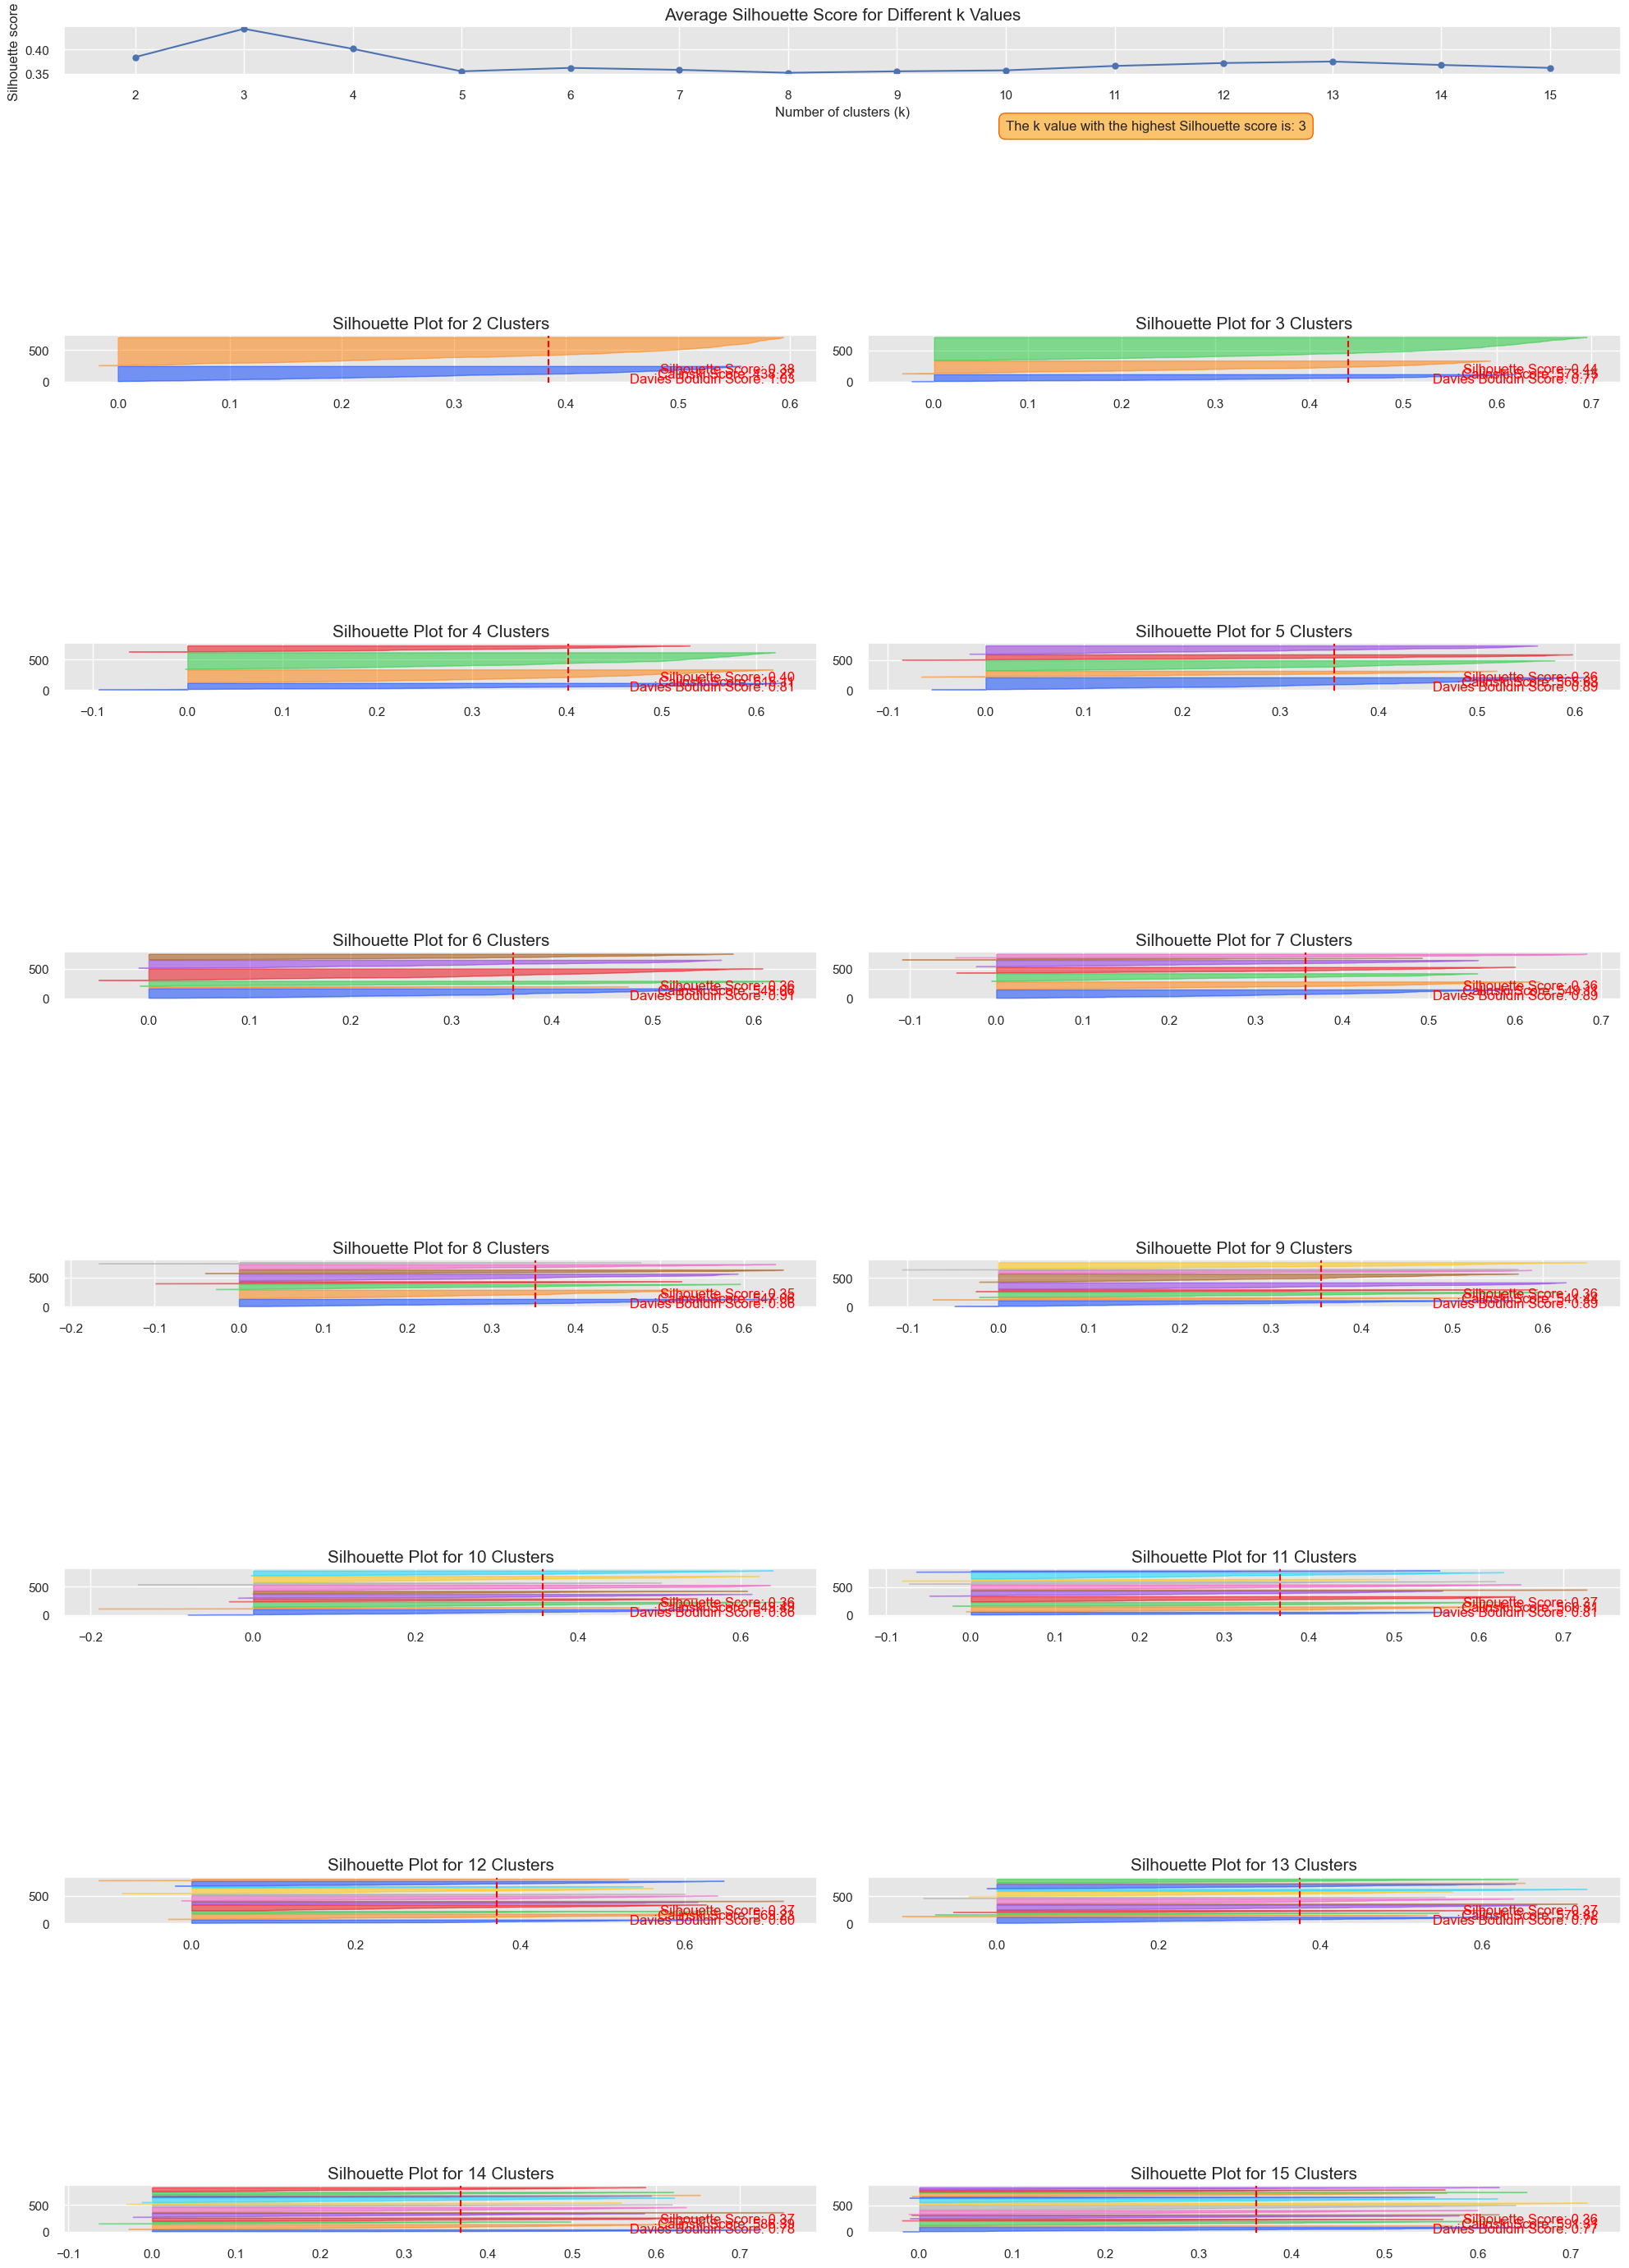

In [73]:
silhouette_analysis(features_pca, 2, 15, figsize=(20, 50))

In [74]:
optimal_cluster = 3

# Apply KMeans clustering using the optimal cluster
kmeans = KMeans(n_clusters=optimal_cluster, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(features_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label,_) in
                enumerate(cluster_frequencies.most_common())}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
features['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
features_pca['cluster'] = new_labels

In [75]:
# Find the closest timeserie to the centroid of each point
def get_closest_to_centroid(kmeans, cluster_idx, data):
    cluster_data = data[data["cluster"] == cluster_idx][["PC1", "PC2"]]
    centroids = kmeans.cluster_centers_[[cluster_idx]]
    distances = cdist(cluster_data, centroids, 'euclidean')
    idx_min = np.where(distances == min(distances))[0][0]
    return cluster_data.iloc[idx_min, :].name

In [76]:
centroids = {}
for i in range(optimal_cluster):
    centroids[i] = get_closest_to_centroid(kmeans, i, features_pca)

In [77]:
# Metrics
sil_score = round(silhouette_score(features_pca, new_labels),3)
calinski_score = round(calinski_harabasz_score(features_pca, new_labels),3)
davies_score = round(davies_bouldin_score(features_pca, new_labels),3)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------+
|         Metric          |  Value  |
+-------------------------+---------+
|    Silhouette Score     |  0.522  |
| Calinski Harabasz Score | 733.387 |
|  Davies Bouldin Score   |  0.715  |
+-------------------------+---------+


### 4.1 Cluster Distribution Visualization

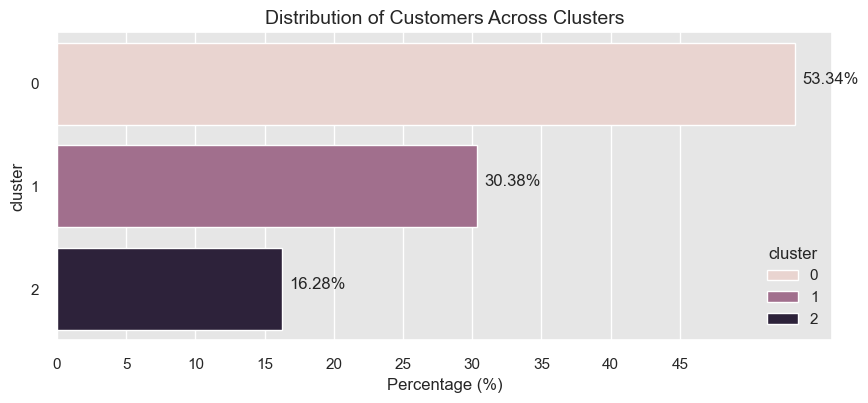

In [78]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (features_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['cluster', 'Percentage']
cluster_percentage.sort_values(by='cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='cluster', data=cluster_percentage, orient='h', hue='cluster')

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()


### 4.2 2D Visualization of Top Principal Components

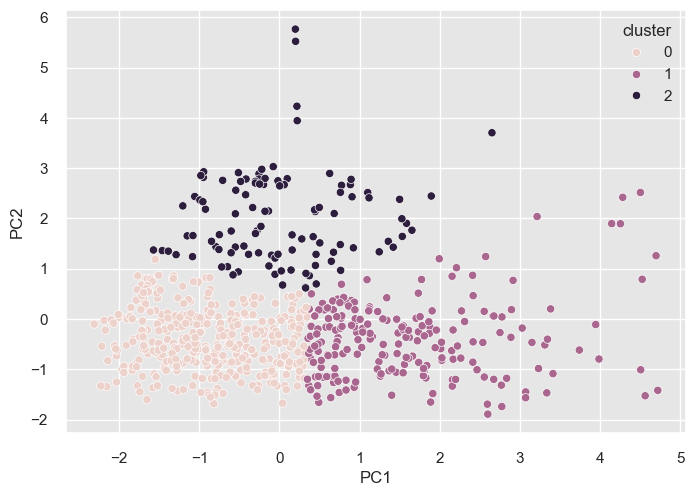

In [79]:
# Add data points for each cluster separately and specify the color
ax = sns.scatterplot(x=features_pca['PC1'], y=features_pca['PC2'],
                      hue=features_pca["cluster"])

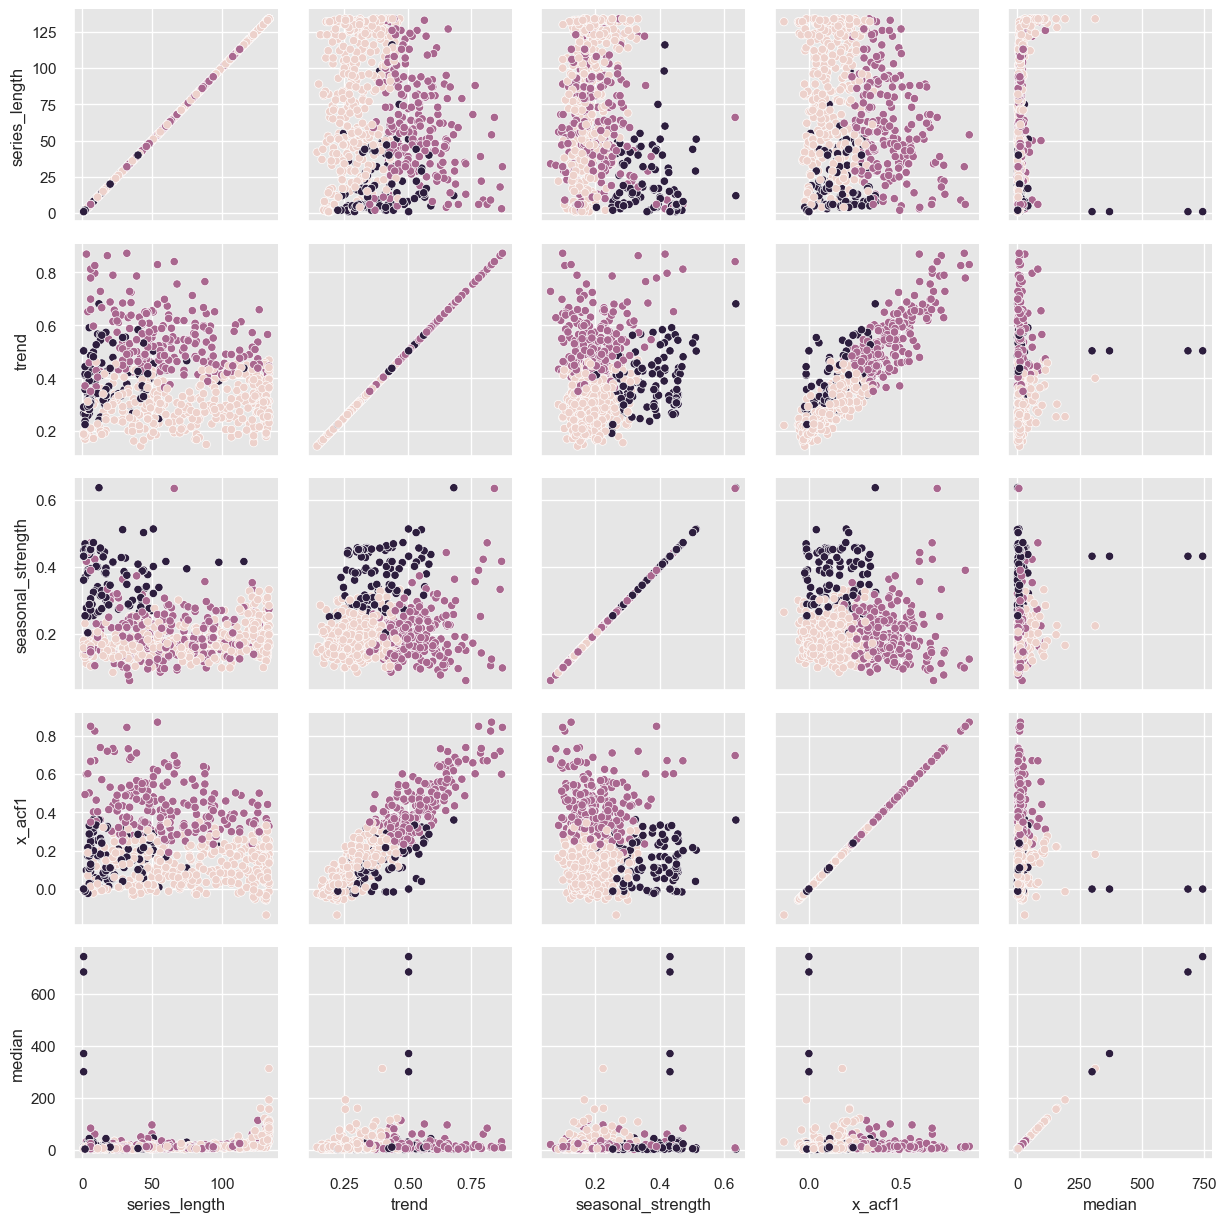

In [80]:
ax = sns.PairGrid(features, hue="cluster")
ax.map(sns.scatterplot)

# Save the files

In [81]:
features['centroid'] = features.index.isin(centroids.values())

In [82]:
features[features["centroid"]==True]

,series_length,trend,seasonal_strength,x_acf1,median,cluster,centroid
unique_id,,,,,,,
F22200167_CLR000088,17,0.253012,0.234233,0.110794,2.0,0,True
M10000009_194011TCX,42,0.323233,0.280692,0.104508,10.5,2,True
M10000030_CLR000021,40,0.463204,0.191771,0.533358,7.0,1,True


In [83]:
features.to_csv("data/clustered_products.csv")

In [84]:
df_cluster = features[["cluster"]]

In [85]:
df_cluster

,cluster
unique_id,
F00001015_CLR000021,0
F00001015_CLR000023,0
F00001111_151304TCX,0
F00001111_193924TPX,0
F00001111_CLR000021,0
...,...
M24200035_CLR000023,1
M24400042_CLR001588,1
M24900011_180515TCX,2


In [86]:
df_cltrain = df_train.merge(df_cluster, how="left", on="unique_id")

In [87]:
df_cltest = df_test.merge(df_cluster, how="left", on="unique_id")

In [88]:
df_cltrain.to_csv("data/train_clustered.csv")
df_cltest.to_csv("data/test_clustered.csv")